In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency

# Initial preprocessement

### Dataset Description

This dataset contains information on credit card clients in Taiwan from 2005. Each row represents a client, and the columns include demographic, financial, and payment history variables. The main goal is to predict whether a client will default on their credit card payment in the next month.

 **Original dataset size:** 30,000 rows (clients), 25 columns (features)

**Variable meanings**

- **ID**: Unique identifier for each client.
- **LIMIT_BAL**: Amount of given credit (NT dollar).
- **SEX**: Gender (1 = male, 2 = female; mapped to labels).
- **EDUCATION**: Education level (1 = graduate school, 2 = university, 3 = high school, 4 = others; 0, 5, 6 treated as unknown).
- **MARRIAGE**: Marital status (1 = married, 2 = single, 3 = divorce; 0 = unknown).
- **AGE**: Age in years.
- **PAY_0 to PAY_6**: Repayment status for the past 7 months (September to April;-2 = no consumption, -1 = pay duly, 1 = payment delay for one month, etc.).
- **BILL_AMT1 to BILL_AMT6**: Amount of bill statement (NT dollar) for each month (April to September).
- **PAY_AMT1 to PAY_AMT6**: Amount paid in the previous month (NT dollar) for each month (April to September).
- **default payment next month**: Target variable (1 = default, 0 = not default).

In [10]:
# Load the dataset
dataset_path = '../data/raw/default_of_credit_card_clients.xls'
data = pd.read_excel(dataset_path, header=1)


# Convert specific columns to categorical types
categorical_features = [
    'SEX', 'EDUCATION', 'MARRIAGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'default payment next month'
]

# Manually create the list of numerical features
numerical_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                     'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

target = 'default payment next month'

for col in categorical_cols:
    data[col] = data[col].astype('category')
data['ID'] = data['ID'].astype(str)

# Map categorical codes to labels and replace unknown values with nan
data['SEX'] = data['SEX'].map({1: 'male', 2: 'female'}).astype('category')

data['EDUCATION'] = data['EDUCATION'].map({
    1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others',
    5: np.nan, 6: np.nan, 0: np.nan
}).astype('category')

data['MARRIAGE'] = data['MARRIAGE'].map({
    1: 'married', 2: 'single', 3: 'divorce',
    0: np.nan
}).astype('category')


# Set a specific order for categorical variables
education_order = ['graduate school', 'high school', 'university', 'others']
data['EDUCATION'] = data['EDUCATION'].cat.reorder_categories(education_order, ordered=True)

# For MARRIAGE
marriage_order = ['single', 'married', 'divorce']
data['MARRIAGE'] = data['MARRIAGE'].cat.reorder_categories(marriage_order, ordered=True)


# Display the first few rows of the dataset
print(data.head())
print("Types: ", data.dtypes)

  ID  LIMIT_BAL     SEX   EDUCATION MARRIAGE  AGE PAY_0 PAY_2 PAY_3 PAY_4  \
0  1      20000  female  university  married   24     2     2    -1    -1   
1  2     120000  female  university   single   26    -1     2     0     0   
2  3      90000  female  university   single   34     0     0     0     0   
3  4      50000  female  university  married   37     0     0     0     0   
4  5      50000    male  university  married   57    -1     0    -1     0   

   ... BILL_AMT4 BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  \
0  ...         0         0          0         0       689         0         0   
1  ...      3272      3455       3261         0      1000      1000      1000   
2  ...     14331     14948      15549      1518      1500      1000      1000   
3  ...     28314     28959      29547      2000      2019      1200      1100   
4  ...     20940     19146      19131      2000     36681     10000      9000   

   PAY_AMT5  PAY_AMT6  default payment next month 

In [8]:
# Check for missing values and unique values
print("Missing values: ", data.isnull().sum())

Missing values:  ID                              0
LIMIT_BAL                       0
SEX                             0
EDUCATION                     345
MARRIAGE                       54
AGE                             0
PAY_0                           0
PAY_2                           0
PAY_3                           0
PAY_4                           0
PAY_5                           0
PAY_6                           0
BILL_AMT1                       0
BILL_AMT2                       0
BILL_AMT3                       0
BILL_AMT4                       0
BILL_AMT5                       0
BILL_AMT6                       0
PAY_AMT1                        0
PAY_AMT2                        0
PAY_AMT3                        0
PAY_AMT4                        0
PAY_AMT5                        0
PAY_AMT6                        0
default payment next month      0
dtype: int64


In [24]:
# Remove rows with any missing values and print how many rows were discarded
initial_shape = data.shape
data = data.dropna()
final_shape = data.shape
print(f"Removed {initial_shape[0] - final_shape[0]} rows with missing values.")
print(f"Data shape after dropping missing values: {final_shape}")

Removed 0 rows with missing values.
Data shape after dropping missing values: (29601, 25)


## Analysis of Categorical Variables

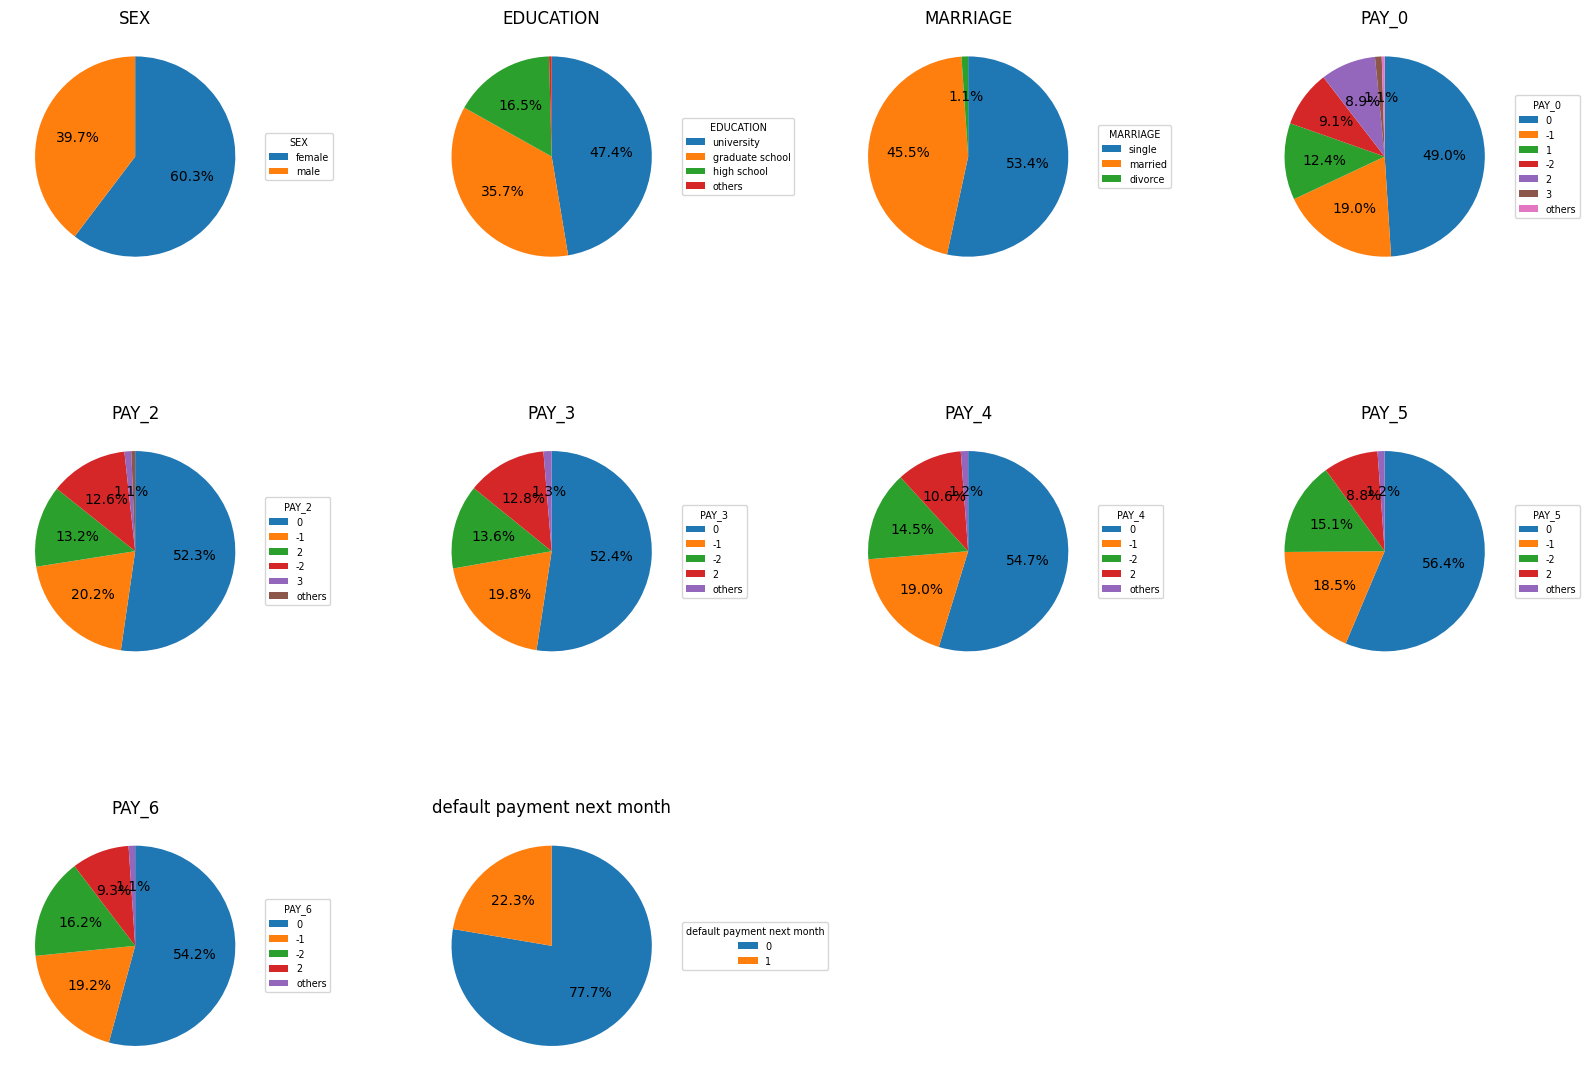

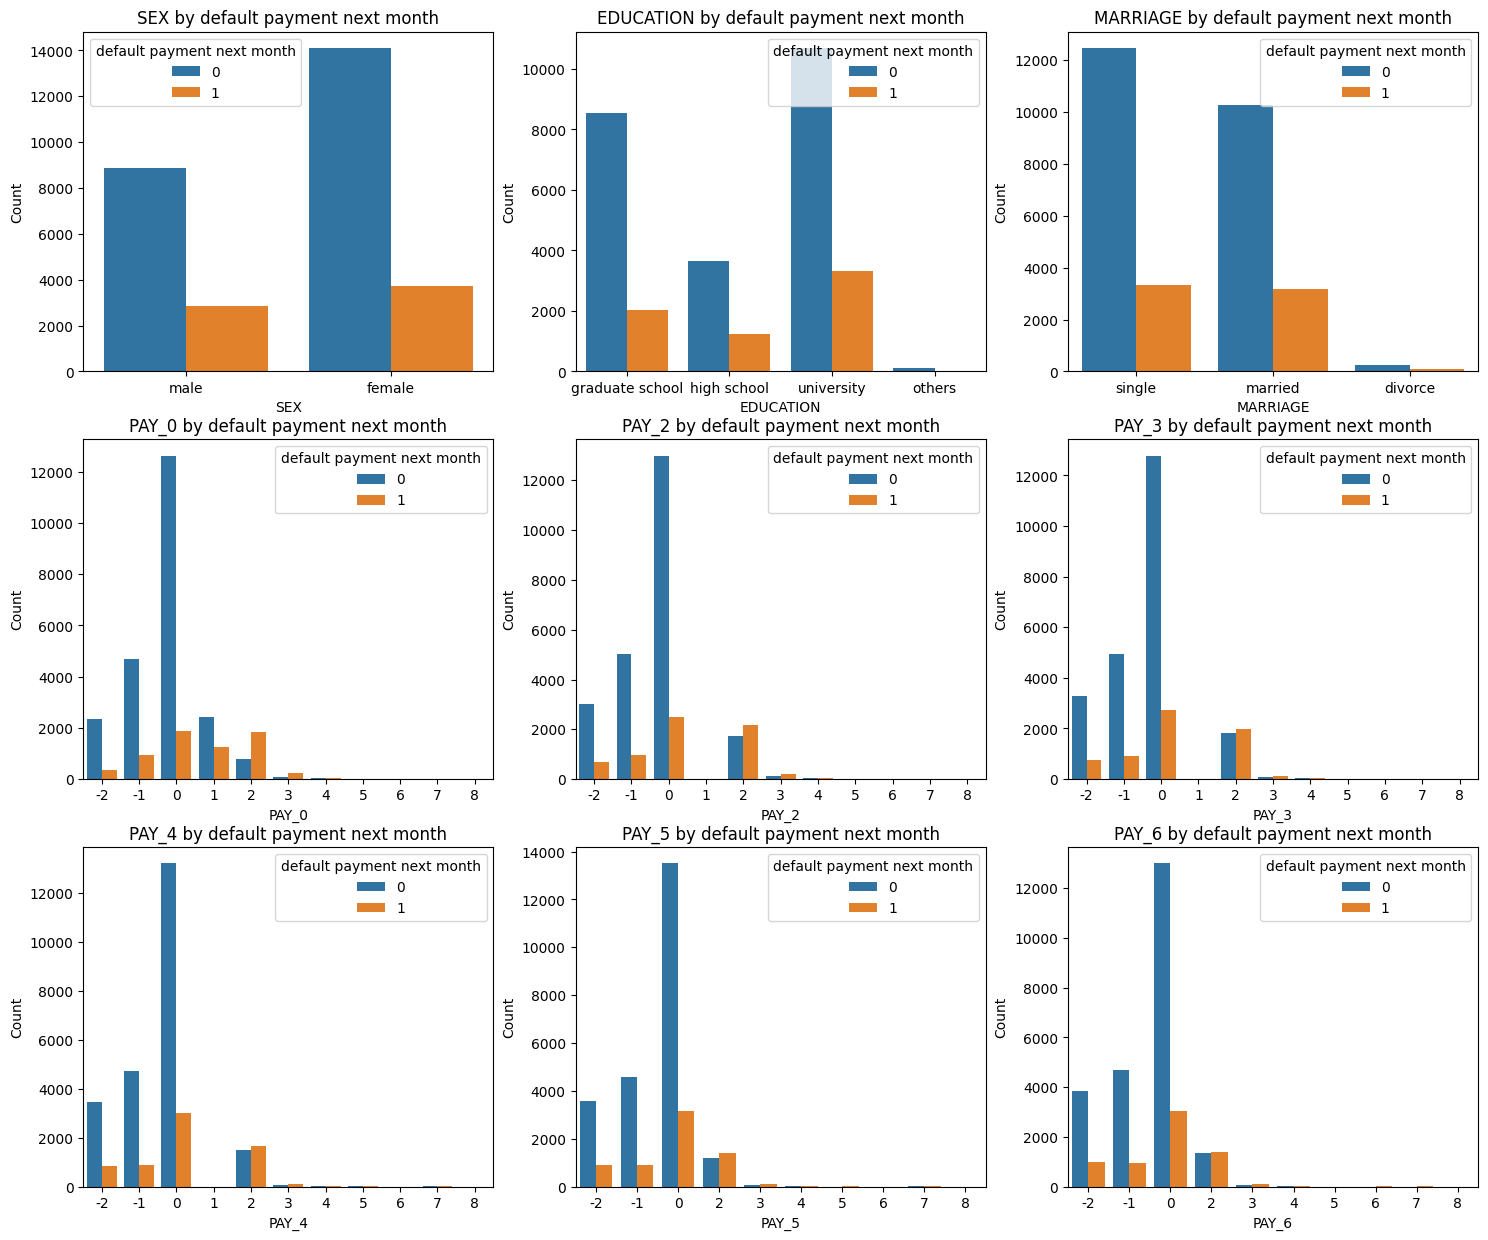

In [25]:
# Panel of pie plots for the categorical variables with smaller legend box, smaller pies, and grouping <1% as 'others'
target = 'default payment next month'
categorical_cols = [col for col in data.select_dtypes(include='category').columns if col != target]+[target]

n_cols = 4
n_rows = int(np.ceil(len(categorical_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))  # smaller pies

for idx, col in enumerate(categorical_cols):
    ax = axes[idx // n_cols, idx % n_cols]
    counts = data[col].value_counts(dropna=False)
    total = counts.sum()
    percentages = counts / total
    # Group categories below 1% as 'others'
    mask = percentages < 0.01
    if mask.any():
        others_count = counts[mask].sum()
        counts = counts[~mask]
        counts['others'] = others_count
    labels = [str(i) for i in counts.index]
    wedges, texts, autotexts = ax.pie(
        counts,
        labels=None,
        autopct=lambda pct: ('%1.1f%%' % pct) if pct >= 1 else '',
        startangle=90,
        counterclock=False
    )
    ax.set_title(col)
    ax.set_ylabel('')
    # Place the legend to the right of the pie and make the font smaller
    ax.legend(
        wedges, labels, title=col,
        loc='center left', bbox_to_anchor=(1, 0.5),
        fontsize='x-small', title_fontsize='x-small'
    )

# Remove empty subplots if any
for j in range(idx + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()


# Panel of categorical variable distributions by target

target = 'default payment next month'
categorical_cols = [col for col in data.select_dtypes(include='category').columns if col != target]

n_cols = 3
n_rows = int(np.ceil(len(categorical_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

for idx, col in enumerate(categorical_cols):
    ax = axes[idx // n_cols, idx % n_cols]
    sns.countplot(x=col, hue=target, data=data, ax=ax)
    ax.set_title(f'{col} by {target}')
    ax.legend(title=target)
    ax.set_xlabel(col)
    ax.set_ylabel('Count')

# Remove empty subplots if any
for j in range(idx + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])




In [73]:
# Analysis of Categorical Variables with respect to the target

target = 'default payment next month'
categorical_cols = [col for col in data.select_dtypes(include='category').columns if col != target]

for col in categorical_cols:
    print(f"--- {col} ---")
    print("Counts:\n", data[col].value_counts(dropna=False))
    print("Proportions:\n", data[col].value_counts(normalize=True, dropna=False))
    print("Unique values:", data[col].unique())
    print("\n")
    

--- SEX ---
Counts:
 SEX
female    18112
male      11888
Name: count, dtype: int64
Proportions:
 SEX
female    0.603733
male      0.396267
Name: proportion, dtype: float64
Unique values: ['female', 'male']
Categories (2, object): ['male', 'female']


--- EDUCATION ---
Counts:
 EDUCATION
university         14030
graduate school    10585
high school         4917
NaN                  345
others               123
Name: count, dtype: int64
Proportions:
 EDUCATION
university         0.467667
graduate school    0.352833
high school        0.163900
NaN                0.011500
others             0.004100
Name: proportion, dtype: float64
Unique values: ['university', 'graduate school', 'high school', NaN, 'others']
Categories (4, object): ['graduate school' < 'high school' < 'university' < 'others']


--- MARRIAGE ---
Counts:
 MARRIAGE
single     15964
married    13659
divorce      323
NaN           54
Name: count, dtype: int64
Proportions:
 MARRIAGE
single     0.532133
married    0.455300
divor

In [26]:
for col in categorical_cols:
    contingency = pd.crosstab(data[col], data[target])
    chi2, p, dof, ex = chi2_contingency(contingency)
    
    # Check minimum expected frequency
    min_expected = np.min(ex)
    
    print(f"\n--- {col} ---")
    print(f"Chi-square: {chi2:.2f}")
    print(f"p-value: {p:.2e}")
    print(f"Minimum expected frequency: {min_expected:.2f}")
    
    # Calculate effect size (Cramér's V)
    n = contingency.sum().sum()
    phi2 = chi2/n
    r, k = contingency.shape
    cramers_v = np.sqrt(phi2/min(k-1, r-1))
    
    print(f"Cramér's V: {cramers_v:.4f}")


--- SEX ---
Chi-square: 46.73
p-value: 8.15e-12
Minimum expected frequency: 2620.94
Cramér's V: 0.0397

--- EDUCATION ---
Chi-square: 118.72
p-value: 1.45e-25
Minimum expected frequency: 27.45
Cramér's V: 0.0633

--- MARRIAGE ---
Chi-square: 32.00
p-value: 1.13e-07
Minimum expected frequency: 70.96
Cramér's V: 0.0329

--- PAY_0 ---
Chi-square: 5342.61
p-value: 0.00e+00
Minimum expected frequency: 2.01
Cramér's V: 0.4248

--- PAY_2 ---
Chi-square: 3444.93
p-value: 0.00e+00
Minimum expected frequency: 0.22
Cramér's V: 0.3411

--- PAY_3 ---
Chi-square: 2587.83
p-value: 0.00e+00
Minimum expected frequency: 0.67
Cramér's V: 0.2957

--- PAY_4 ---
Chi-square: 2310.54
p-value: 0.00e+00
Minimum expected frequency: 0.45
Cramér's V: 0.2794

--- PAY_5 ---
Chi-square: 2173.77
p-value: 0.00e+00
Minimum expected frequency: 0.22
Cramér's V: 0.2710

--- PAY_6 ---
Chi-square: 1866.57
p-value: 0.00e+00
Minimum expected frequency: 0.45
Cramér's V: 0.2511


### Summary of Findings about Categorical Features:

1. The dataset contains several categorical features: SEX, EDUCATION, MARRIAGE, PAY_0 to PAY_6, and the target variable 'default payment next month'.
2. After cleaning, all missing or unknown values in categorical columns were removed, resulting in 29,601 rows.
3. The distribution of categories in each feature was visualized using pie charts and count plots, with rare categories (<1%) grouped as 'others' for clarity.
4. There are clear imbalances in some features (e.g., most clients are 'female', 'university' educated, and 'married').
5. The target variable ('default payment next month') is also imbalanced, with about 22% defaults and 78% non-defaults.
6. Chi-square tests for independence between each categorical feature and the target showed significant associations (very low p-values), indicating that these features are related to default risk.
7. Effect sizes (Cramér's V) suggest moderate associations for some features (e.g., payment status variables), while others have weaker effects.
8. The minimum expected frequencies in contingency tables are generally adequate, supporting the validity of the chi-square results.

Overall, categorical features show meaningful patterns and associations with the target, justifying their inclusion in further modeling and analysis.

## Numerical features Analysis

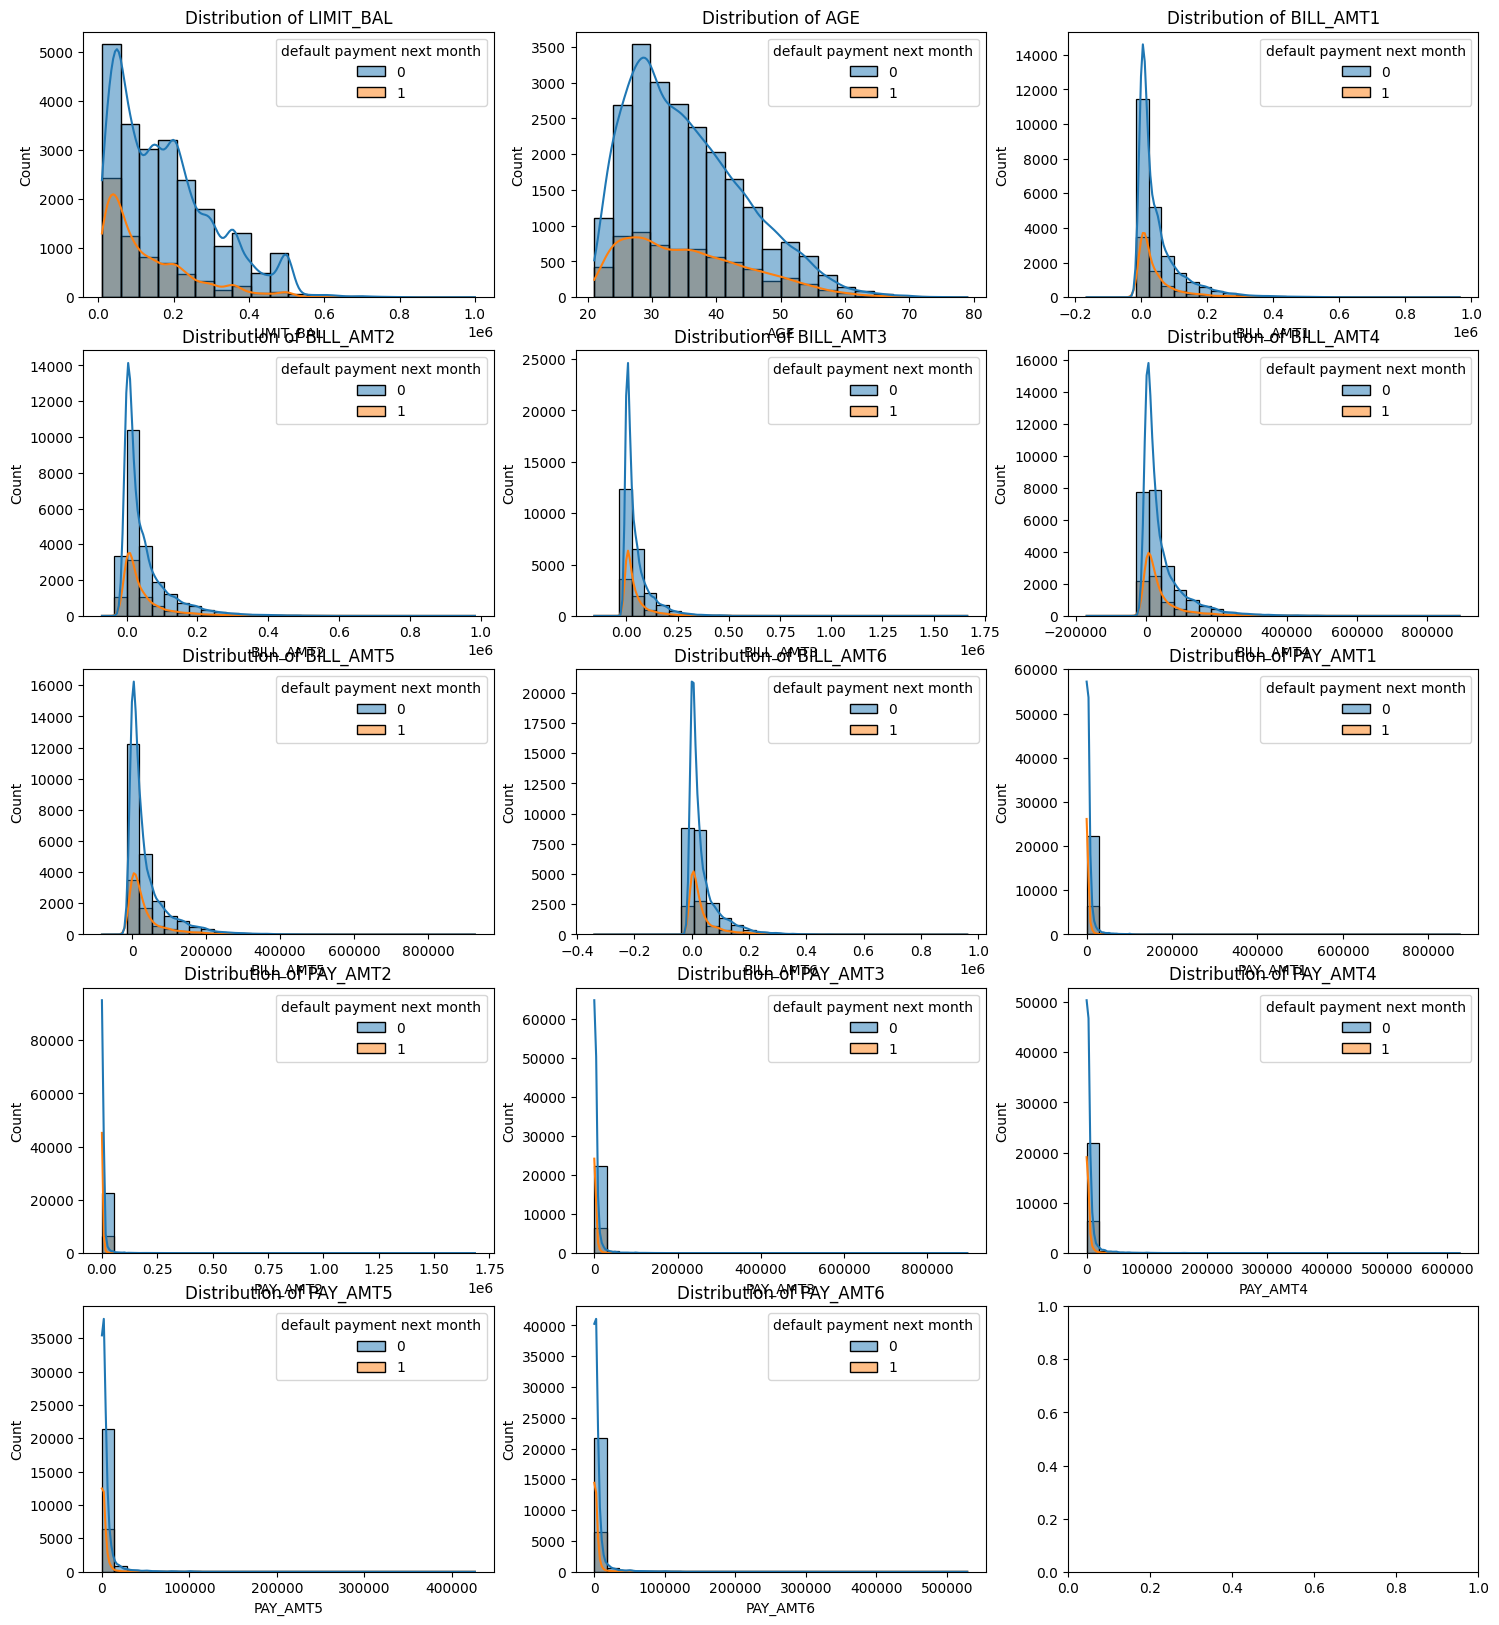

In [27]:
# Panel of numerical feature distributions by target, with custom bins

numerical_features = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                      'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

# Suggest bins for each feature based on their value ranges
bins_dict = {
    'LIMIT_BAL': 20,
    'AGE': 20,
    'BILL_AMT1': 30,
    'BILL_AMT2': 30,
    'BILL_AMT3': 30,
    'BILL_AMT4': 30,
    'BILL_AMT5': 30,
    'BILL_AMT6': 30,
    'PAY_AMT1': 30,
    'PAY_AMT2': 30,
    'PAY_AMT3': 30,
    'PAY_AMT4': 30,
    'PAY_AMT5': 30,
    'PAY_AMT6': 30
}

n_cols = 3
n_rows = int(np.ceil(len(numerical_features) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))

for idx, col in enumerate(numerical_features):
    ax = axes[idx // n_cols, idx % n_cols]
    bins = bins_dict.get(col, 30)
    sns.histplot(data, x=col, hue='default payment next month', bins=bins, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

Text(0.5, 1.0, 'Correlation Matrix')

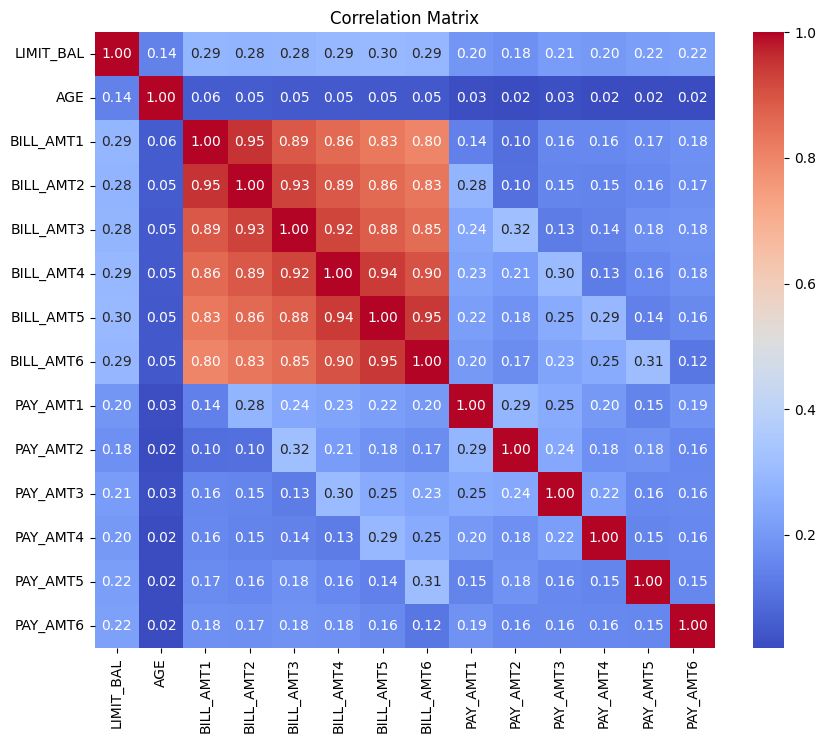

In [21]:
# Correlation heatmap with all data
plt.figure(figsize=(10, 8))
sns.heatmap(data[numerical_features].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')

In [87]:
print(data.describe)

<bound method NDFrame.describe of           ID  LIMIT_BAL     SEX    EDUCATION MARRIAGE  AGE PAY_0 PAY_2 PAY_3  \
0          1      20000  female   university  married   24     2     2    -1   
1          2     120000  female   university   single   26    -1     2     0   
2          3      90000  female   university   single   34     0     0     0   
3          4      50000  female   university  married   37     0     0     0   
4          5      50000    male   university  married   57    -1     0    -1   
...      ...        ...     ...          ...      ...  ...   ...   ...   ...   
29995  29996     220000    male  high school  married   39     0     0     0   
29996  29997     150000    male  high school   single   43    -1    -1    -1   
29997  29998      30000    male   university   single   37     4     3     2   
29998  29999      80000    male  high school  married   41     1    -1     0   
29999  30000      50000    male   university  married   46     0     0     0   

     

# Feature Engineering

### Transformation of PAY_0 to PAY_6 Variables

The original variables **PAY_0 to PAY_6** represent the repayment status for the past 7 months, with values:
- **-2**: No consumption
- **-1**: Paid duly (on time)
- **0, 1, 2, ...**: Number of months payment is delayed

#### Why transform these variables?

- The original encoding mixes special cases (no consumption, paid duly) with ordinal delay values, which can confuse machine learning models.
- By separating these cases, we make the data more interpretable and allow models to better distinguish between good payment behavior and payment delays.
- This transformation also enables us to use the delay as a true ordinal feature.

#### Transformation steps

For each PAY_X column (where X = 0 to 6):
1. **Create two binary features:**
   - `PAY_X_no_consumption`: 1 if value is -2 (no consumption), else 0
   - `PAY_X_paid_duly`: 1 if value is -1 (paid duly), else 0
2. **Create an ordinal delay feature:**
   - `PAY_X_delay`: 0 if value is -2 or -1 (no delay), otherwise the number of months delayed (original value if ≥ 0)

This process separates good payment behavior from delays, making the features more meaningful and useful for

In [46]:
# Create a new dataset with engineered PAY_X features and remove the original PAY_X columns

# List of PAY_X columns to transform and remove
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Copy data for transformation
new_data = data.copy()

# Create new features
for col in pay_cols:
    new_data[f'{col}_no_consumption'] = (new_data[col] == -2).astype(int)
    new_data[f'{col}_paid_duly'] = (new_data[col] == -1).astype(int)
    new_data[f'{col}_delay'] = new_data[col].apply(lambda x: 0 if x < 0 else x)
new_data[target] = new_data[target].astype(int)

# Sanity check: ensure new columns exist and original columns will be dropped
print("New columns added:", [f"{col}_no_consumption" for col in pay_cols] +
      [f"{col}_paid_duly" for col in pay_cols] +
      [f"{col}_delay" for col in pay_cols])

# Remove the original PAY_X columns
new_data = new_data.drop(columns=pay_cols)

# Check that original columns are removed
print("Remaining columns:", new_data.columns)
print("New data shape:", new_data.shape)
print("Column types:\n", new_data.dtypes)
print(new_data.head())

New columns added: ['PAY_0_no_consumption', 'PAY_2_no_consumption', 'PAY_3_no_consumption', 'PAY_4_no_consumption', 'PAY_5_no_consumption', 'PAY_6_no_consumption', 'PAY_0_paid_duly', 'PAY_2_paid_duly', 'PAY_3_paid_duly', 'PAY_4_paid_duly', 'PAY_5_paid_duly', 'PAY_6_paid_duly', 'PAY_0_delay', 'PAY_2_delay', 'PAY_3_delay', 'PAY_4_delay', 'PAY_5_delay', 'PAY_6_delay']
Remaining columns: Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'PAY_0_no_consumption', 'PAY_0_paid_duly',
       'PAY_0_delay', 'PAY_2_no_consumption', 'PAY_2_paid_duly', 'PAY_2_delay',
       'PAY_3_no_consumption', 'PAY_3_paid_duly', 'PAY_3_delay',
       'PAY_4_no_consumption', 'PAY_4_paid_duly', 'PAY_4_delay',
       'PAY_5_no_consumption', 'PAY_5_paid_duly', 'PAY_5_delay',
       'PAY_6_no_consumption'

In [ ]:
# Dummyfication (one-hot encoding) of categorical variables in new_data

# Exclude the target variable from dummyfication
categorical_to_dummy = [col for col in new_data.select_dtypes(include='category').columns if col != target]

# Perform one-hot encoding, keeping the target as category
data_encoded = pd.get_dummies(new_data, columns=categorical_to_dummy, drop_first=False)

# Show the resulting columns and shape
print("Encoded data shape:", data_encoded.shape)
print("Columns after dummyfication:", data_encoded.columns.tolist())
print("Shape of data after dummyfication:", data_encoded.shape)
print("Data types after dummyfication:\n", data_encoded.dtypes)
print(data_encoded.head())

Encoded data shape: (29601, 43)
Columns after dummyfication: ['ID', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month', 'PAY_0_no_consumption', 'PAY_0_paid_duly', 'PAY_0_delay', 'PAY_2_no_consumption', 'PAY_2_paid_duly', 'PAY_2_delay', 'PAY_3_no_consumption', 'PAY_3_paid_duly', 'PAY_3_delay', 'PAY_4_no_consumption', 'PAY_4_paid_duly', 'PAY_4_delay', 'PAY_5_no_consumption', 'PAY_5_paid_duly', 'PAY_5_delay', 'PAY_6_no_consumption', 'PAY_6_paid_duly', 'PAY_6_delay', 'SEX_male', 'SEX_female', 'EDUCATION_graduate school', 'EDUCATION_high school', 'EDUCATION_university', 'EDUCATION_others', 'MARRIAGE_single', 'MARRIAGE_married', 'MARRIAGE_divorce']
  ID  LIMIT_BAL  AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0  1      20000   24       3913       3102        689          0          0   
1  2     120000   26       2682       1725 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare data for PCA: use only numerical columns from data_encoded
# Exclude ID and target variable
pca_features = [col for col in data_encoded.columns if data_encoded[col].dtype in [np.int64, np.float64, bool] and col not in ['default payment next month']]
X = data_encoded[pca_features].astype(float)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = explained_var.cumsum()

print("Explained variance ratio (first 10 components):", explained_var[:10])
print("Cumulative explained variance (first 10 components):", cumulative_var[:10])

# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.arange(1, len(cumulative_var) + 1), cumulative_var, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA on Mixed Data (Numerical + Dummified Categorical)')
plt.grid(True)
plt.show()